In [101]:
import pandas as pd
import plotly.express as px
import datetime as dt
df = pd.read_csv("train.csv",index_col=0)
df_test = pd.read_csv("test.csv",index_col=0)
df.Datum = pd.to_datetime(df["Datum"])
df.set_index(df["Datum"],inplace=True)

#df["Wochentag"] = df["Datum"].dt.dayofweek
df["Arbeitszeit"] = (df["Datum"].dt.hour.between(8,17))&(df["Datum"].dt.dayofweek < 5)
#df["Wochenende"] = df["Datum"].dt.dayofweek > 4
df.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
#df = df.applymap(lambda x: True if x else np.nan)
#df.fillna(method="ffill",inplace=True)
df.dropna(inplace=True)
df.head(5)

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Arbeitszeit
Datum,,,,,
2017-01-25 17:51:00,23.18,27.2720,721.25,1,True
2017-01-25 17:51:59,23.15,27.2675,714.00,1,True
2017-01-25 17:53:00,23.15,27.2450,713.50,1,True
2017-01-25 17:54:00,23.15,27.2000,708.25,1,True
2017-01-25 17:55:00,23.10,27.2000,704.50,1,True


In [102]:
df.describe()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit
count,14225.000000,14225.000000,14225.000000,14225.000000
mean,21.005722,25.941156,628.075549,0.256591
std,1.148986,4.581969,279.382924,0.436767
min,19.000000,16.745000,412.750000,0.000000
25%,20.290000,22.675000,446.000000,0.000000
50%,20.830000,25.722500,512.000000,0.000000
75%,21.700000,28.650000,694.750000,1.000000
max,24.408333,39.117500,2028.500000,1.000000


## Ausreißer werden entfernt
- macht keinen großen Unterschied für die Performance aber etwas sauberer
- fehlende Werte füllen wir nicht auf weil es nicht genug Daten gibt um sie verlässlich intelligent zu füllen


In [103]:
features = ["Luftfeuchtigkeit", "Temperatur", "CO2"]
for feature in features:
    df[f"Ausreisserdropper{feature}"] = df[feature]/df[feature].shift(1)
#    df = df[~df["Ausreisserdropper"].between(0.998,1.002)]
#    cols = ['col_1', 'col_2'] # one or more
    Q1 = df[f"Ausreisserdropper{feature}"].quantile(0.04)
    Q3 = df[f"Ausreisserdropper{feature}"].quantile(0.96)
    IQR = Q3 - Q1
    df = df[~((df[f"Ausreisserdropper{feature}"] < (Q1 - 1.5 * IQR)) |(df[f"Ausreisserdropper{feature}"] > (Q3 + 1.5 * IQR)))]
#px.histogram(df[~df["Ausreisserdropper"].between(0.996,1.004)],x="Ausreisserdropper")
df.drop(columns=["AusreisserdropperTemperatur","AusreisserdropperLuftfeuchtigkeit","AusreisserdropperCO2"],inplace=True)
df.dropna(inplace=True)


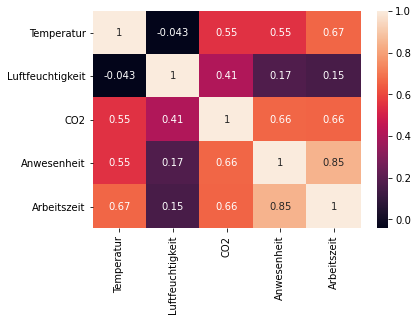

In [104]:
from seaborn import heatmap
heatmap(df.corr(),annot=True)

In [105]:
px.box(df,y=["Luftfeuchtigkeit","Temperatur"])

In [214]:
px.bar(df.resample("h").mean(),y="CO2",color="Anwesenheit")

In [107]:
px.scatter(df,x="CO2",y="Luftfeuchtigkeit",color="Anwesenheit")

## Funktion fürs Training

In [216]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier


label = "Anwesenheit"

def train_model(classifier,label=label,scaler=None):
    print(pd.DataFrame(columns=df.columns))
    X = df.drop(columns=[label])
    y = df[label]
    if scaler:
        X = scaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
    
    m = classifier()
    %time m.fit(X_train, y_train)
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train)))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))
    
    fpr, tpr, thresholds = roc_curve(y_test,m.predict(X_test))
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
    display.plot()

## Logistische Regression

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 17 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      7863
           1       0.83      0.96      0.89      2703

    accuracy                           0.94     10566
   macro avg       0.91      0.94      0.92     10566
weighted avg       0.94      0.94      0.94     10566

Testdaten:
               precision    recall  f1-score   support

           0      0.986     0.921     0.953      2597
           1      0.813     0.964     0.882       925

    accuracy                          0.932      3522
   macro avg      0.900     0.943     0.917      3522
weighted avg      0.941     0.932     0.934      3522



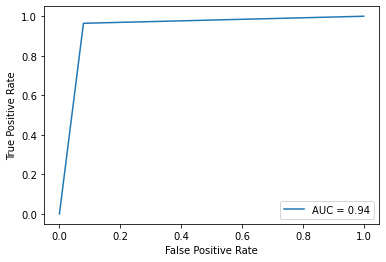

In [220]:
train_model(classifier=linear_model.LogisticRegression,scaler=MinMaxScaler)

## Random Forest

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 744 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7828
           1       1.00      1.00      1.00      2738

    accuracy                           1.00     10566
   macro avg       1.00      1.00      1.00     10566
weighted avg       1.00      1.00      1.00     10566

Testdaten:
               precision    recall  f1-score   support

           0      0.993     0.991     0.992      2632
           1      0.974     0.979     0.976       890

    accuracy                          0.988      3522
   macro avg      0.984     0.985     0.984      3522
weighted avg      0.988     0.988     0.988      3522



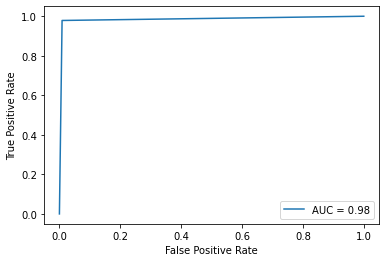

In [219]:
train_model(classifier=RandomForestClassifier,scaler=MinMaxScaler)

## XGB Classifier

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
[11:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gurr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Wall time: 376 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7859
           1       1.00      1.00      1.00      2707

    accuracy                           1.00     10566
   macro avg       1.00      1.00      1.00     10566
weighted avg       1.00      1.00      1.00     10566

Testdaten:
               precision    recall  f1-score   support

           0      0.989     0.990     0.990      2601
           1      0.972     0.970     0.971       921

    accuracy                          0.985      3522
   macro avg      0.980     0.980     0.980      3522
weighted avg      0.985     0.985     0.985      3522



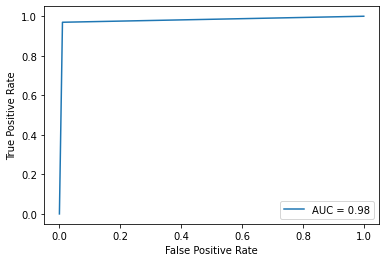

In [218]:
train_model(classifier=XGBClassifier,scaler=MinMaxScaler)

## SVC

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 492 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      7821
           1       0.87      0.94      0.91      2745

    accuracy                           0.95     10566
   macro avg       0.93      0.95      0.94     10566
weighted avg       0.95      0.95      0.95     10566

Testdaten:
               precision    recall  f1-score   support

           0      0.984     0.951     0.967      2639
           1      0.868     0.952     0.908       883

    accuracy                          0.952      3522
   macro avg      0.926     0.952     0.938      3522
weighted avg      0.955     0.952     0.952      3522



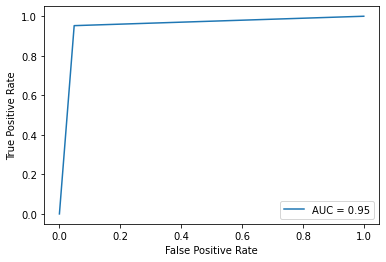

In [221]:
train_model(classifier=SVC,scaler=MinMaxScaler)